In [1]:
import pandas as pd
import re, random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud, STOPWORDS
import spacy
import scispacy
nlp = spacy.load('en_core_web_sm')
symptom_nlp = spacy.load("en_ner_bc5cdr_md") 
organ_nlp = spacy.load("en_ner_bionlp13cg_md")

#### Load Data

In [2]:
data_dir = "/Users/suhas/Documents/CodeStash/ProjectRonin/drugsCom_raw/"
df = pd.read_csv(data_dir+'drugsComTrain_raw.tsv', sep="\t", parse_dates=["date"])
df_test = pd.read_csv(data_dir+'drugsComTest_raw.tsv', sep="\t", parse_dates=["date"])
df["review"]= df["review"].str.replace("039", "'", case = False)
df["review"]= df["review"].str.replace("&#';", "'", case = False)
df_test["review"]= df_test["review"].str.replace("039", "'", case = False)
df_test["review"]= df_test["review"].str.replace("&#';", "'", case = False)

In [3]:
print("Shape of train set --> {}".format(df.shape))
print("Shape of test set --> {}".format(df_test.shape))

Shape of train set --> (161297, 7)
Shape of test set --> (53766, 7)


These are additional explanations for variables.

- drugName (categorical): name of drug
- condition (categorical): name of condition
- review (text): patient review
- rating (numerical): 10 star patient rating
- date (date): date of review entry
- usefulCount (numerical): number of users who found review useful

In [4]:
# drop rows with missing values
df = df.dropna()
df_test = df_test.dropna()
df.isna().sum()
df.shape

(160398, 7)

In [5]:
df_test.dtypes

Unnamed: 0              int64
drugName               object
condition              object
review                 object
rating                float64
date           datetime64[ns]
usefulCount             int64
dtype: object

In [6]:
duplicate_review = df[df.duplicated(['review'])]
#duplicate_review

In [7]:
#df.review.nunique()

In [8]:
# Many reviews are duplicated and have been assigned to 2 drugNames 
# where 1 is usually a broader term for the drug and the second one the brand name. 
# We will therefore remove the duplicates and always keep the first value.
df = df.drop_duplicates(subset='review', keep="first")
df_test = df_test.drop_duplicates(subset='review', keep="first")
df.shape

(112105, 7)

In [9]:
#df.groupby('condition').agg('sum')
df_comment = df[df['condition'].str.contains('comment')]
#df_comment

In [10]:
# Dropping rows that contain incorrect information 
df = df[~df['condition'].str.contains('comment')]
df_test = df_test[~df_test['condition'].str.contains('comment')]

In [11]:
df_all = pd.concat([df,df_test])
df_all.shape

(158988, 7)

In [12]:
comment_words = ' '
stopwords = set(STOPWORDS) 
for review in df_all['review']: 
    # typecaste each val to string 
    review = str(review).lower() 
    # split the value 
    tokens = review.split()
    comment_words = comment_words + ' '.join(tokens)

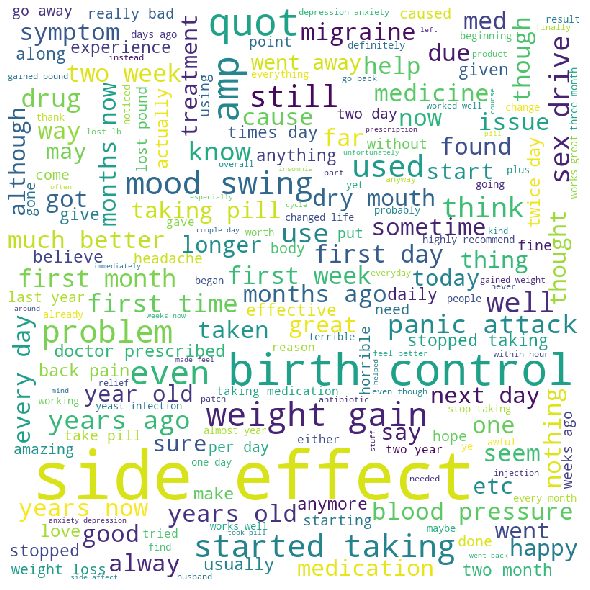

In [13]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [18]:
#First let's check some NERs in first 10 reviews and remove date, time, ordinal and cardinal.
#count = 0
#for review in df['review']:
#    if count < 11:
#        doc = nlp(review)
#        ents = [(e.text, e.label_) for e in doc.ents if e.label_ not in ('DATE', 'TIME', 'ORDINAL', 'CARDINAL')]
#        print(ents)
#    count += 1

In [14]:
def process_review(review):
    processed_token = []
    for token in review.split():
        token = ''.join(e.lower() for e in token if e.isalnum())
        processed_token.append(token)
    return ' '.join(processed_token)

In [15]:
drug_list = df['drugName'].value_counts().index.tolist()
drug_list = [x.lower() for x in drug_list]

def clean_ner_data(data):
    cleaned_data = []
    for i in range(0,len(data)):
        ents = data[i][1]['entities']
        end = 0
        res = []
        for ent in ents:
            if ent[0] > end:
                res.append(ent)
            end = ent[1]
        cleaned_data.append((data[i][0],{'entities':res}))     
    return cleaned_data

#Step 1: Let's create the training data
count = 0
TRAIN_DATA = []
for _, item in df.iterrows():
    ent_dict = {}
    if count < 10000:
        review = process_review(item['review'])
        #We will find a drug and its positions once and add to the visited items.
        visited_items = []
        entities = []
        for token in review.split():
            if token in drug_list:
                for i in re.finditer(token, review):
                    if token not in visited_items:
                        entity = (i.span()[0], i.span()[1], 'DRUG')
                        visited_items.append(token)
                        entities.append(entity)
        if len(entities) > 0:
            ent_dict['entities'] = entities
            train_item = (review, ent_dict)
            TRAIN_DATA.append(train_item)
            count+=1
CLEAN_TRAIN_DATA = clean_ner_data(TRAIN_DATA)

In [16]:
n_iter = 10
def train():
    from spacy.util import minibatch, compounding
    nlp = spacy.blank("en")  # create blank Language class
    print("Created blank 'en' model")
    
    if "ner" not in nlp.pipe_names:
        ner = nlp.create_pipe("ner")
        nlp.add_pipe(ner, last=True)
    # otherwise, get it so we can add labels
    else:
        ner = nlp.get_pipe("ner")
        
    # add labels
    for _, annotations in CLEAN_TRAIN_DATA:
        for ent in annotations.get("entities"):
            ner.add_label(ent[2])
            
    nlp.begin_training()
    for itn in range(n_iter):
        random.shuffle(CLEAN_TRAIN_DATA)
        losses = {}
        # batch up the examples using spaCy's minibatch
        batches = minibatch(CLEAN_TRAIN_DATA, size=compounding(4.0, 32.0, 1.001))
        for batch in batches:
            texts, annotations = zip(*batch)
            nlp.update(
                texts,  # batch of texts
                annotations,  # batch of annotations
                drop=0.5,  # dropout - make it harder to memorise data
                losses=losses,
            )
        print("Losses", losses)
    return nlp

In [ ]:
#Step 2: Let's train custom model with the training data
nlp_drug = train()

Created blank 'en' model


In [ ]:
#Test the model
for text, _ in CLEAN_TRAIN_DATA[:10]:
    doc = nlp_drug(text)
    print("Entities", [(ent.text, ent.label_) for ent in doc.ents])

In [24]:
test_reviews = df_test.iloc[-10:, :]['review']
for review in test_reviews:
    review = process_review(review)
    print(review)
    doc = nlp_drug(review)
    print("Entities", [(ent.text, ent.label_) for ent in doc.ents])
    print('________________________')

it didnt help me at all i craved chocolate all the time not worth the 7500 a month
Entities []
________________________
i now suffer from excessive tiredness and lack of energy and i am consulting my gp about an alternative treatment
Entities []
________________________
treatment for adhd save my life dont believe all the hype and the stigma around this diagnosis and treatment it is a real condition there is real treatment and it makes a real and profound difference to the lives of people with this debilitating condition so dont be afraid to seek help if you think you might have adhd it is not just childhood illness in in my opinion it generally consists persists in some form for the duration of your life just like any other disease
Entities []
________________________
this is my 3rd time taking this medicine first 2 times my shin bones hurt bad for 2 weeks this time my left thumb and palm so far hurts badly but this medicine does work for what ailes me i just hope my shin bones dont h

In [87]:
#df_all['symptoms'] = df_all['review'].apply(lambda x: [(ent.text, ent.label_) for ent in symptom_nlp(x).ents])
#df_all['organ'] = df_all['review'].apply(lambda x: [(ent.text, ent.label_) for ent in organ_nlp(x).ents])

In [145]:
df_all

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount,symptoms
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,2012-05-20,27,"[(Bystolic 5 Mg, CHEMICAL)]"
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,2010-04-27,192,[]
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,2009-12-14,17,"[(oral contraceptive, CHEMICAL), (gestodene, C..."
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,2015-11-03,10,"[(cramps, DISEASE), (cramps, DISEASE)]"
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,2016-11-27,37,"[(Suboxone, CHEMICAL), (Suboxone, CHEMICAL), (..."
...,...,...,...,...,...,...,...,...
53760,123432,Apri,Birth Control,"""I started taking Apri about 7 months ago. My ...",9.0,2010-08-25,18,"[(Apri, CHEMICAL), (ovarian cysts, DISEASE), (..."
53761,159999,Tamoxifen,"Breast Cancer, Prevention","""I have taken Tamoxifen for 5 years. Side effe...",10.0,2014-09-13,43,"[(Tamoxifen, CHEMICAL), (depression, DISEASE),..."
53762,140714,Escitalopram,Anxiety,"""I've been taking Lexapro (escitaploprgram) si...",9.0,2016-10-08,11,"[(Zoloft, CHEMICAL), (anxiety, DISEASE), (depr..."
53763,130945,Levonorgestrel,Birth Control,"""I'm married, 34 years old and I have no kids....",8.0,2010-11-15,7,"[(cramping, DISEASE), (cramps, DISEASE), (levo..."


In [ ]:
for i in range(0,len(df_all)):
    review = process_review(df_all['review'][i])
    
for review in test_reviews:
    review = process_review(review)
    print(review)
    symp_doc = symptom_nlp(review)
    organ_doc = organ_nlp(review)
    print("Entities", [(ent.text, ent.label_) for ent in symp_doc.ents])
    print("Entities", [(ent.text, ent.label_) for ent in organ_doc.ents])
    print()

In [30]:
rev = "Up to 800mg seems to work about once every 2nd day still in excruciating pain and it seems the medical fraternity don\'t give a damn."

In [31]:
symp_doc = symptom_nlp(rev)
organ_doc = organ_nlp(rev)
print("Entities", [(ent.text, ent.label_) for ent in symp_doc.ents])
print("Entities", [(ent.text, ent.label_) for ent in organ_doc.ents])
print()

Entities [('pain', 'DISEASE')]
Entities []



In [29]:
df['review'][161289]

'"Up to 800mg seems to work about once every 2nd day still in excruciating pain and it seems the medical fraternity don\'t give a damn."'

In [93]:
df_test['review'][0]

'"I\'ve tried a few antidepressants over the years (citalopram, fluoxetine, amitriptyline), but none of those helped with my depression, insomnia &amp; anxiety. My doctor suggested and changed me onto 45mg mirtazapine and this medicine has saved my life. Thankfully I have had no side effects especially the most common - weight gain, I\'ve actually lost alot of weight. I still have suicidal thoughts but mirtazapine has saved me."'

In [134]:
[(ent.text, ent.label_) for ent in symptom_nlp('i have taken the medicine and now i do not have any pain in my head').ents]

[('pain', 'DISEASE')]

In [ ]:
for review in test_reviews:
    review = process_review(review)
    print(review)
    symp_doc = symptom_nlp(review)
    organ_doc = organ_nlp(review)
    print("Entities", [(ent.text, ent.label_) for ent in symp_doc.ents])
    print("Entities", [(ent.text, ent.label_) for ent in organ_doc.ents])
    print()

In [96]:
review = process_review(df_test['review'][0])
print(review)
symp_doc = symptom_nlp(df_test['review'][0])
organ_doc = organ_nlp(df_test['review'][0])
print("Entities", [(ent.text, ent.label_) for ent in symp_doc.ents if ent.label_ in ['DISEASE']])
print("Entities", [(ent.text, ent.label_) for ent in organ_doc.ents])
print()

ive tried a few antidepressants over the years citalopram fluoxetine amitriptyline but none of those helped with my depression insomnia amp anxiety my doctor suggested and changed me onto 45mg mirtazapine and this medicine has saved my life thankfully i have had no side effects especially the most common  weight gain ive actually lost alot of weight i still have suicidal thoughts but mirtazapine has saved me
Entities [('depression', 'DISEASE'), ('insomnia', 'DISEASE'), ('anxiety', 'DISEASE'), ('weight gain', 'DISEASE'), ('suicidal thoughts', 'DISEASE')]
Entities [('antidepressants', 'SIMPLE_CHEMICAL'), ('citalopram', 'SIMPLE_CHEMICAL'), ('fluoxetine', 'SIMPLE_CHEMICAL'), ('amitriptyline', 'SIMPLE_CHEMICAL'), ('mirtazapine', 'SIMPLE_CHEMICAL'), ('mirtazapine', 'SIMPLE_CHEMICAL')]



In [154]:
df_symptoms = df_test
df_symptoms = df_symptoms.reset_index().drop(['index'], axis=1)
df_symptoms['symptoms'] = ''
df_symptoms['affected_organs'] = ''
for i in range(0,len(df_symptoms)):
    df_symptoms['symptoms'][i] = [(ent.text) for ent in symptom_nlp(df_symptoms['review'][i]).ents if ent.label_ in ['DISEASE']]
    df_symptoms['affected_organs'][i] = [(ent.text) for ent in organ_nlp(df_symptoms['review'][i]).ents if ent.label_ in ['ORGAN']]

/Users/suhas/ronin/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/suhas/ronin/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [155]:
df_symptoms

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount,symptoms,affected_organs
0,163740,Mirtazapine,Depression,"""I've tried a few antidepressants over the yea...",10.0,2012-02-28,22,"[depression, insomnia, anxiety, weight gain, s...",[]
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn's disease and has done very ...",8.0,2009-05-17,17,"[Crohn's disease, diarrhea]",[]
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9.0,2017-09-29,3,[],[]
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9.0,2017-03-05,35,"[obesity, sugar/carb addiction]",[stomach]
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9.0,2015-10-22,4,"[headaches, nausea, cramping]",[]
...,...,...,...,...,...,...,...,...,...
47775,123432,Apri,Birth Control,"""I started taking Apri about 7 months ago. My ...",9.0,2010-08-25,18,"[ovarian cysts, cramps]",[]
47776,159999,Tamoxifen,"Breast Cancer, Prevention","""I have taken Tamoxifen for 5 years. Side effe...",10.0,2014-09-13,43,[depression],"[uterus, uterus]"
47777,140714,Escitalopram,Anxiety,"""I've been taking Lexapro (escitaploprgram) si...",9.0,2016-10-08,11,"[anxiety, depression]",[]
47778,130945,Levonorgestrel,Birth Control,"""I'm married, 34 years old and I have no kids....",8.0,2010-11-15,7,"[cramping, cramps, cramping]",[]


In [157]:
"""df1 = (df_symptoms.groupby('condition')['symptoms']
       .apply(lambda x: ','.join(set(x.dropna())))
       .reset_index())"""
cond_drug_symp = df_symptoms.groupby(['condition', 'drugName']).agg({'symptoms':'sum','affected_organs':'sum', 'rating':'mean'}).reset_index()

def wordListToFreqDict(wordlist):
    wordfreq = [[x.lower() for x in wordlist].count(p) for p in [x.lower() for x in wordlist]]
    return dict(list(zip([x.lower() for x in wordlist],wordfreq)))

cond_drug_symp['symptom_counts'] = cond_drug_symp['symptoms'].apply(lambda x:wordListToFreqDict(x))
cond_drug_symp['affected_organ_counts'] = cond_drug_symp['affected_organs'].apply(lambda x:wordListToFreqDict(x))

In [158]:
cond_drug_symp

,condition,drugName,symptoms,affected_organs,rating,symptom_counts,affected_organ_counts
0,ADHD,Adderall,"[ADD, nervousness, loss of appetite, dry mouth...","[heart, liver, teeth, brain, brain, muscle]",8.080645,"{'add': 8, 'nervousness': 1, 'loss of appetite...","{'heart': 1, 'liver': 1, 'teeth': 1, 'brain': ..."
1,ADHD,Adderall XR,"[ADHD, depressed, anxiety, anxious, OCD, OCD, ...","[teeth, erectile, liver, kidneys, heart]",8.653846,"{'adhd': 4, 'depressed': 1, 'anxiety': 2, 'anx...","{'teeth': 1, 'erectile': 1, 'liver': 1, 'kidne..."
2,ADHD,Adzenys XR-ODT,"[ADHD, ADHD]",[],4.000000,{'adhd': 2},{}
3,ADHD,Amphetamine,"[heart burn, anxiety, chest pain, anger diarr...","[heart, heart]",5.888889,"{'heart burn': 1, 'anxiety': 1, 'chest pain': ...",{'heart': 2}
4,ADHD,Amphetamine / dextroamphetamine,"[ADHD, fatigue, headache, loss of appetite, ir...","[eye, brain, cheek, teeth, teeth, brain, forea...",7.788889,"{'adhd': 38, 'fatigue': 4, 'headache': 3, 'los...","{'eye': 1, 'brain': 4, 'cheek': 1, 'teeth': 2,..."
...,...,...,...,...,...,...,...
5091,zen Shoulde,Aleve,"[pain, pain]","[skin, stomach]",3.500000,{'pain': 2},"{'skin': 1, 'stomach': 1}"
5092,zen Shoulde,Diclofenac,[],[],6.000000,{},{}
5093,zen Shoulde,Naproxen,"[pain, Pain]",[],1.000000,{'pain': 2},{}
5094,zen Shoulde,Relafen,[pain],[],9.000000,{'pain': 1},{}


In [129]:
def wordListToFreqDict(wordlist):
    wordfreq = [wordlist.count(p) for p in wordlist]
    return dict(list(zip(wordlist,wordfreq)))

TypeError: unsupported operand type(s) for /: 'dict' and 'int'

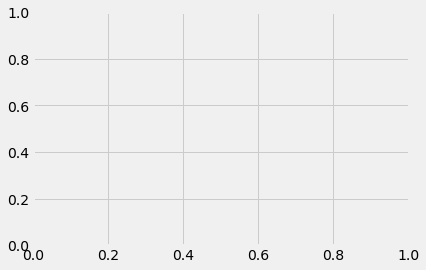

In [153]:
sns.distplot(wordListToFreqDict(cond_drug_symp['symptoms'][0]))

In [130]:
wordListToFreqDict(cond_drug_symp['symptoms'][0])

{'ADD': 8,
 'nervousness': 1,
 'loss of appetite': 3,
 'dry mouth': 6,
 'dizziness': 2,
 'depressed': 3,
 'anxiety': 6,
 'headaches': 1,
 'ADD/ADHD': 2,
 'gnatting': 1,
 'ADHD': 22,
 'depression': 6,
 'fibromyalgia': 1,
 'pain': 4,
 'drug abuse': 1,
 'irritable': 3,
 'depression/anxiety': 1,
 "parkinson's disease": 1,
 'bipolar disorder': 3,
 'itch': 1,
 'irritability': 1,
 'fatigue': 3,
 'Ritain': 1,
 'weight loss': 1,
 'migraines': 1,
 'bad reaction': 1,
 'insomnia': 1,
 'irritable mood': 1,
 'sleeplessness': 1,
 'tiredness': 1,
 'shock': 1,
 'mental disorders': 1,
 'bad headaches': 1,
 'restless': 1,
 'emotionless': 1,
 'Inattentive ADHD': 1,
 'blurred vision': 2,
 'muscle tics': 1,
 'OCD': 1,
 "Tourette's": 1,
 'A.D.D': 1,
 'drug addiction': 1}

In [152]:
cond_drug_symp

,condition,drugName,symptoms,rating,symptom_counts
0,ADHD,Adderall,"[ADD, nervousness, loss of appetite, dry mouth...",8.080645,"{'add': 8, 'nervousness': 1, 'loss of appetite..."
1,ADHD,Adderall XR,"[ADHD, depressed, anxiety, anxious, OCD, OCD, ...",8.653846,"{'adhd': 4, 'depressed': 1, 'anxiety': 2, 'anx..."
2,ADHD,Adzenys XR-ODT,"[ADHD, ADHD]",4.000000,{'adhd': 2}
3,ADHD,Amphetamine,"[heart burn, anxiety, chest pain, anger diarr...",5.888889,"{'heart burn': 1, 'anxiety': 1, 'chest pain': ..."
4,ADHD,Amphetamine / dextroamphetamine,"[ADHD, fatigue, headache, loss of appetite, ir...",7.788889,"{'adhd': 38, 'fatigue': 4, 'headache': 3, 'los..."
...,...,...,...,...,...
5091,zen Shoulde,Aleve,"[pain, pain]",3.500000,{'pain': 2}
5092,zen Shoulde,Diclofenac,[],6.000000,{}
5093,zen Shoulde,Naproxen,"[pain, Pain]",1.000000,{'pain': 2}
5094,zen Shoulde,Relafen,[pain],9.000000,{'pain': 1}


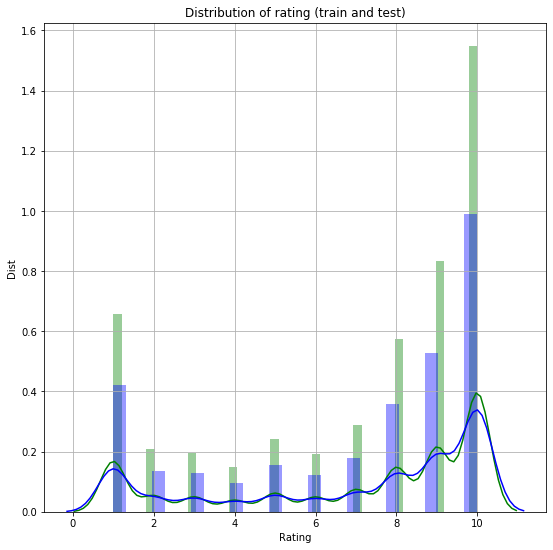

In [41]:
plt.figure(figsize=(9,9))

sns.distplot(df['rating'], color='green')
sns.distplot(df_test['rating'],color='blue')
plt.grid()
plt.xlabel('Rating')
plt.ylabel('Dist')
plt.title("Distribution of rating (train and test)")

plt.show()

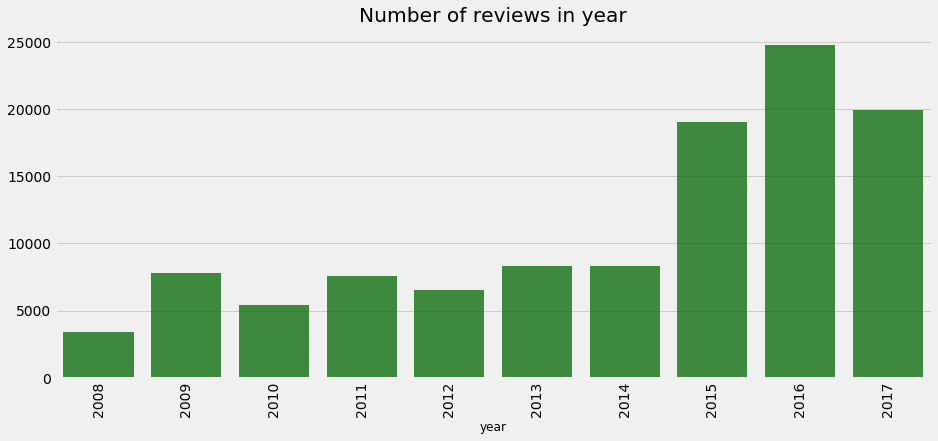

In [92]:
cnt_srs = df['date'].dt.year.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('year', fontsize=12)
plt.ylabel('', fontsize=12)
plt.title("Number of reviews in year")
plt.show()

Text(0, 0.5, 'Count')

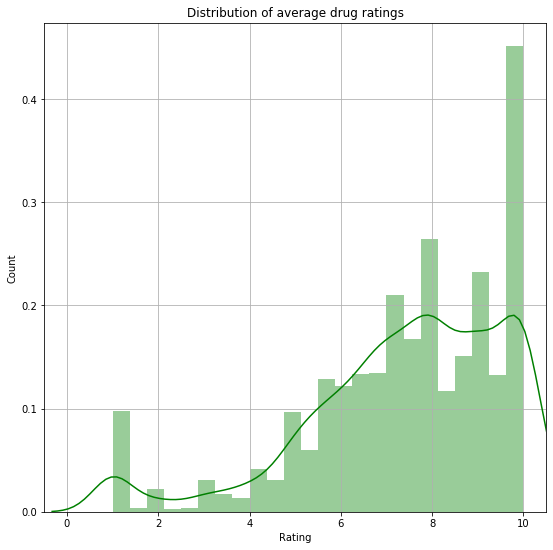

In [49]:
plt.figure(figsize=(9,9))
rating_avgs = (df['rating'].groupby(df['drugName']).mean())
sns.distplot(rating_avgs, color='green')
plt.grid()
plt.title('Distribution of average drug ratings')
plt.xlim(-.5,10.5)
plt.xlabel('Rating')
plt.ylabel('Count')

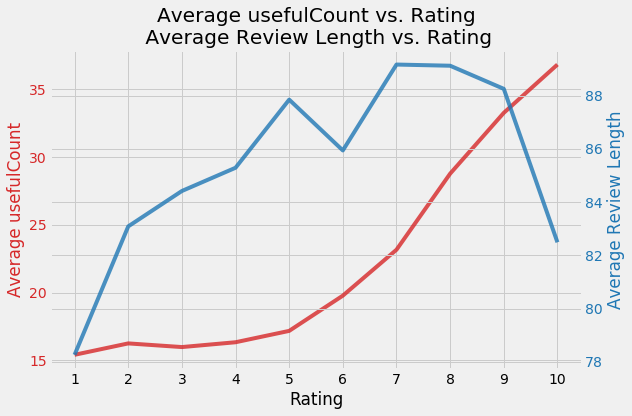

In [85]:
# Create some mock data
df['reviewLength'] = df.review.apply(lambda x: len(x.split()))
# plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

fig, ax1 = plt.subplots(figsize=(9,6))
t = range(1,11)

color = 'tab:red'
ax1.set_xlabel('Rating')
ax1.set_ylabel('Average usefulCount', color=color)
ax1.plot(t, df.groupby('rating').usefulCount.mean(), color=color, alpha=0.8)
ax1.set_xticks(range(1,11))
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title('Average usefulCount vs. Rating\n Average Review Length vs. Rating')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Average Review Length', color=color)  # we already handled the x-label with ax1
ax2.plot(t, df.groupby('rating').reviewLength.mean(), color=color, alpha=0.8)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

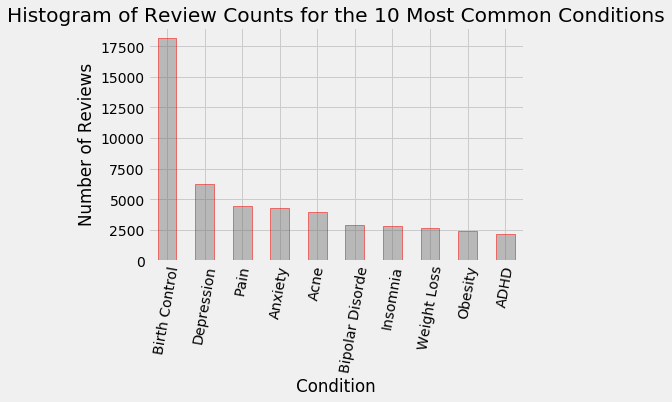

In [86]:
# 10 most common conditions
conditions = df.condition.value_counts().sort_values(ascending=False)
conditions[:10]
conditions[:10].plot(kind='bar', color=tuple(.4 for i in range(4)), edgecolor='red')
plt.title('Histogram of Review Counts for the 10 Most Common Conditions')
plt.xlabel('Condition')
plt.xticks(rotation=80)
plt.ylabel('Number of Reviews');

In [50]:
# Sort train dataframe from most to least useful
useful_train = df.sort_values(by='usefulCount', ascending=False)
useful_train.iloc[:10]

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
6716,96616,Sertraline,Depression,"""I remember reading people's opinions, online,...",10.0,2008-07-31,1291
4249,182560,Mirena,Birth Control,"""I have had my IUD for over a year now and I t...",10.0,2009-04-01,1247
146145,119151,Zoloft,Depression,"""I've been on Zoloft 50mg for over two years. ...",9.0,2008-08-05,949
16889,52305,Adipex-P,Weight Loss,"""I have used this pill off and on for the past...",10.0,2008-10-19,796
2039,62757,Citalopram,Depression,"""I responded after one week. The side effects ...",8.0,2008-03-25,771
5218,107655,Implanon,Birth Control,"""I was very nervous about trying Implanon afte...",10.0,2010-07-19,730
5839,62688,Citalopram,Anxiety and Stress,"""I work for a large Fire Department. I was ha...",8.0,2009-08-31,693
5595,126311,Viibryd,Depression,"""I have had a lot of additional stress added i...",10.0,2011-09-07,693
66536,119081,Zoloft,Depression,"""I am 55 years old and have been taking Zoloft...",10.0,2009-01-18,680
145340,118984,Zoloft,Depression,"""Withoug Zoloft I would probably be dead or ki...",9.0,2010-06-09,644


In [65]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

In [66]:
# Create list (cast to array) of compound polarity sentiment scores for reviews
sentiments = []

for i in df.review:
    sentiments.append(sid.polarity_scores(i).get('compound'))
    
sentiments = np.asarray(sentiments)

In [67]:
useful_train['sentiment'] = pd.Series(data=sentiments)

In [68]:
useful_train = useful_train.reset_index(drop=True)
useful_train.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount,sentiment
0,96616,Sertraline,Depression,"""I remember reading people's opinions, online,...",10.0,2008-07-31,1291,-0.2960
1,182560,Mirena,Birth Control,"""I have had my IUD for over a year now and I t...",10.0,2009-04-01,1247,0.8603
2,119151,Zoloft,Depression,"""I've been on Zoloft 50mg for over two years. ...",9.0,2008-08-05,949,0.7645
3,52305,Adipex-P,Weight Loss,"""I have used this pill off and on for the past...",10.0,2008-10-19,796,0.7184
4,62757,Citalopram,Depression,"""I responded after one week. The side effects ...",8.0,2008-03-25,771,0.9403


Text(0, 0.5, 'Count')

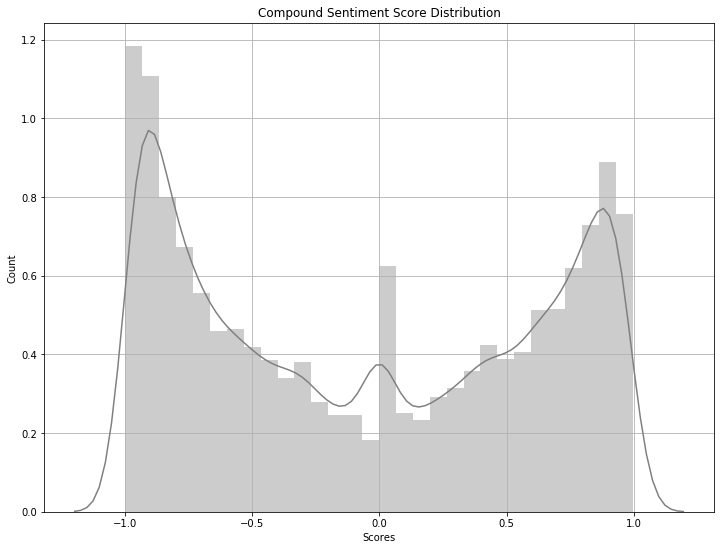

In [69]:
plt.figure(figsize=(12,9))
sns.distplot(useful_train['sentiment'], color='gray', bins=30)
plt.grid()
plt.title('Compound Sentiment Score Distribution')
plt.xlabel('Scores')
plt.ylabel('Count')

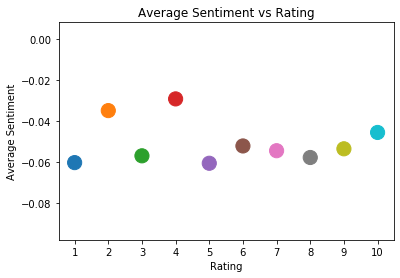

In [70]:
temp_ls = []

for i in range(1, 11):
    temp_ls.append(np.sum(useful_train[useful_train.rating == i].sentiment) / np.sum(useful_train.rating == i))

plt.scatter(x=range(1, 11), y=temp_ls, c=range(1, 11), cmap='tab10', s=200)
plt.title('Average Sentiment vs Rating')
plt.xlabel('Rating')
plt.ylabel('Average Sentiment')
plt.xticks([i for i in range(1, 11)]);

In [71]:
# Create a list of all drugs and their average ratings, cast to dataframe
rate_ls = []

for i in df.drugName.unique():
    
    # Only consider drugs that have at least 10 ratings
    if np.sum(df.drugName == i) >= 10:
        rate_ls.append((i, np.sum(df[df.drugName == i].rating) / np.sum(df.drugName == i)))
    
avg_rate = pd.DataFrame(rate_ls)

In [72]:
# Sort drugs by their ratings, look at top 10 best and worst rated drugs
avg_rate = avg_rate.sort_values(by=[1], ascending=False).reset_index(drop=True)
avg_rate[:10]

,0,1
0,Silver sulfadiazine,9.968750
1,Drixoral Cold and Allergy,9.958333
2,Dexbrompheniramine / pseudoephedrine,9.916667
3,Alosetron,9.818182
4,Aspirin / butalbital / caffeine / codeine,9.800000
5,Desoxyn,9.700000
6,Zelnorm,9.615385
7,Dramamine,9.611111
8,Cyanocobalamin,9.600000
9,Cambia,9.600000


In [74]:
# Make dictionary of conditions, each value will be a dataframe of all of the drugs used to treat the given condition
help_dict = {}

# Iterate over conditions
for i in df.condition.unique():
    
    temp_ls = []
    
    # Iterate over drugs within a given condition
    for j in df[df.condition == i].drugName.unique():
        
        # If there are at least 10 reviews for a drug, save its name and average rating in temporary list
        if np.sum(df.drugName == j) >= 10:
            temp_ls.append((j, np.sum(df[df.drugName == j].rating) / np.sum(df.drugName == j)))
        
    # Save temporary list as a dataframe as a value in help dictionary, sorted best to worst drugs
    help_dict[i] = pd.DataFrame(data=temp_ls, columns=['drug', 'average_rating']).sort_values(by='average_rating', ascending=False).reset_index(drop=True)

In [75]:
help_dict['Birth Control'].iloc[:10]

,drug,average_rating
0,Plan B,8.617128
1,Ortho Evra,7.601449
2,Levonorgestrel,7.470486
3,Kyleena,7.422222
4,Copper,7.350538
5,Beyaz,7.338983
6,Skyla,7.210216
7,Ocella,7.040000
8,Dienogest / estradiol,7.000000
9,Ortho Cyclen,6.909091


In [82]:
help_dict['Cough'].iloc[:10]

,drug,average_rating
0,Chlorpheniramine / hydrocodone,9.296296
1,Tussionex Pennkinetic,9.151515
2,Lortab,8.164179
3,Hydromorphone,8.133690
4,Codeine,8.107143
5,Acetaminophen / hydrocodone,8.022663
6,Hycodan,8.000000
7,Vicodin,7.912281
8,Guaifenesin,7.907216
9,Homatropine / hydrocodone,7.755102


In [81]:
help_dict['ADHD'].iloc[:10]

,drug,average_rating
0,Desoxyn,9.700000
1,Desipramine,9.230769
2,Selegiline,8.789474
3,Daytrana,8.656250
4,Dextroamphetamine,8.626866
5,Dexedrine,8.625000
6,Adderall,8.400000
7,Methamphetamine,8.333333
8,Provigil,8.275362
9,Adderall XR,8.106061


In [78]:
help_dict['Acne'].iloc[-10:]

,drug,average_rating
53,Bactrim DS,5.500000
54,Ethinyl estradiol / norethindrone,5.446217
55,Gildess Fe 1.5 / 30,5.400000
56,Sulfamethoxazole / trimethoprim,5.383562
57,SMZ-TMP DS,5.200000
58,Junel Fe 1.5 / 30,4.933333
59,Loryna,4.925926
60,Tri-Previfem,4.795181
61,Gildess Fe 1 / 20,4.706422
62,Estarylla,3.327273


In [80]:
df.condition.unique()

array(['Left Ventricular Dysfunction', 'ADHD', 'Birth Control',
       'Opiate Dependence', 'Benign Prostatic Hyperplasia',
       'Emergency Contraception', 'Bipolar Disorde', 'Epilepsy',
       'Migraine Prevention', 'Depression', "Crohn's Disease", 'Cough',
       'Obesity', 'Urinary Tract Infection', 'ibromyalgia',
       'Chronic Myelogenous Leukemia', 'HIV Infection', 'Insomnia',
       'Rheumatoid Arthritis', 'Vaginal Yeast Infection',
       'Chlamydia Infection', 'Hirsutism', 'Panic Disorde', 'Migraine',
       'Pain', 'Irritable Bowel Syndrome', 'Osteoarthritis',
       'Constipation', 'Bowel Preparation', 'Psychosis', 'Muscle Spasm',
       'Hepatitis C', 'Overactive Bladde', 'Diabetes, Type 2',
       'Asthma, Maintenance', 'Non-Small Cell Lung Cance',
       'Schizophrenia', 'Dysuria', 'Smoking Cessation', 'Anxiety', 'Acne',
       'emale Infertility', 'Constipation, Acute',
       'Constipation, Drug Induced', 'Erectile Dysfunction',
       'Trigeminal Neuralgia', 'Undera

In [6]:
df['month'] = df.date.apply(lambda i: i.month)
df['day'] = df.date.apply(lambda i: i.day)
df['year'] = df.date.apply(lambda i: i.year)

df_test['month'] = df_test.date.apply(lambda i: i.month)
df_test['day'] = df_test.date.apply(lambda i: i.day)
df_test['year'] = df_test.date.apply(lambda i: i.year)

df['reviewLength'] = df.review.apply(lambda x: len(x.split()))
df_test['reviewLength'] = df_test.review.apply(lambda x: len(x.split()))

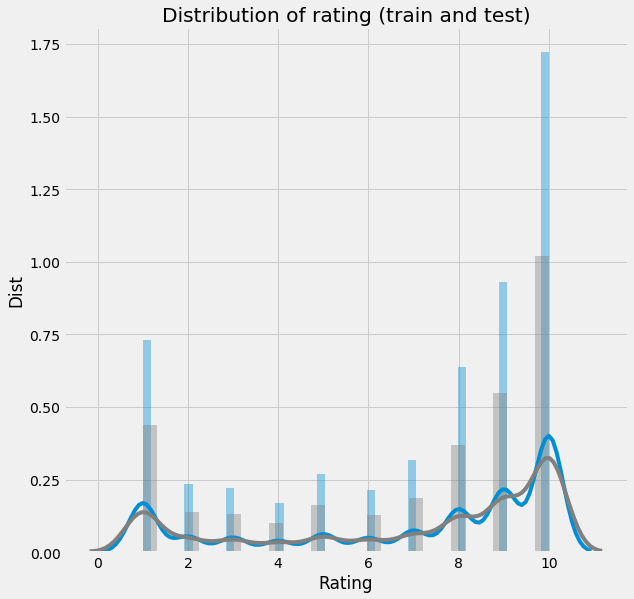

In [30]:
plt.figure(figsize=(9,9))

sns.distplot(df['rating'])
sns.distplot(df_test['rating'],color='gray')

plt.xlabel('Rating')
plt.ylabel('Dist')
plt.title("Distribution of rating (train and test)")

plt.show()

Text(0.5, 1.0, 'Top20 : The number of drugs per condition.')

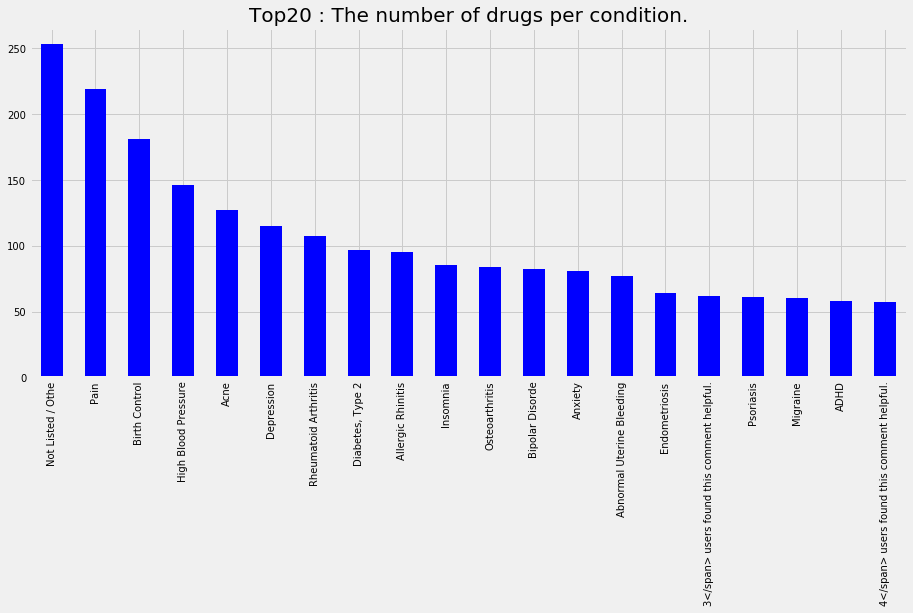

In [9]:
condition_dn = df_all.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
condition_dn[0:20].plot(kind="bar", figsize = (14,6), fontsize = 10,color="blue")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Top20 : The number of drugs per condition.", fontsize = 20)

In [31]:
# Sort train dataframe from most to least useful
useful_train = df.sort_values(by='usefulCount', ascending=False)
useful_train.iloc[:10]

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
6716,96616,Sertraline,Depression,"""I remember reading people&#039;s opinions, on...",10.0,2008-07-31,1291
33552,119152,Zoloft,Depression,"""I remember reading people&#039;s opinions, on...",10.0,2008-07-31,1291
21708,131116,Levonorgestrel,Birth Control,"""I have had my IUD for over a year now and I t...",10.0,2009-04-01,1247
4249,182560,Mirena,Birth Control,"""I have had my IUD for over a year now and I t...",10.0,2009-04-01,1247
146145,119151,Zoloft,Depression,"""I&#039;ve been on Zoloft 50mg for over two ye...",9.0,2008-08-05,949
58608,139141,Phentermine,Weight Loss,"""I have used this pill off and on for the past...",10.0,2008-10-19,796
16889,52305,Adipex-P,Weight Loss,"""I have used this pill off and on for the past...",10.0,2008-10-19,796
2039,62757,Citalopram,Depression,"""I responded after one week. The side effects ...",8.0,2008-03-25,771
152838,89825,Celexa,Depression,"""I responded after one week. The side effects ...",8.0,2008-03-25,771
5218,107655,Implanon,Birth Control,"""I was very nervous about trying Implanon afte...",10.0,2010-07-19,730


In [32]:
# Print top 3 most useful reviews
print("3 most useful reviews: \n")
for i in useful_train.review.iloc[:3]:
    print(i, '\n')

3 most useful reviews: 

"I remember reading people&#039;s opinions, online, of the drug before I took it and it scared me away from it. Then I finally decided to give it a try and it has been the best choice I have made. I have been on it for over 4 months and I feel great. I&#039;m on 100mg and I don&#039;t have any side effects. When I first started I did notice that my hands would tremble but then it subsided. So honestly, don&#039;t listen to all the negativity because what doesn&#039;t work for some works amazing for others. So go based on youself and not everyone else. It may be a blessing in diguise. The pill is not meant to make you be all happy go lucky and see &quot;butterflies and roses&quot;, its meant to help put the chemicals in your mind in balance so you can just be who you are and not overly depressed. I still get sad some times, but that is normal, that is life, and it&#039;s up to people to take control to make a change. I did so by getting on this pill." 

"I remem

In [33]:
# Print 3 of the least useful reviews
print("3 of the least useful reviews: \n")
for i in useful_train.review.iloc[-3:]:
    print(i, '\n')

3 of the least useful reviews: 

"I received Implanon in May of 2008. I am due to have it removed in 6 months however, for the past year I have experienced decrease in sex drive, weight gain of 30lbs and also mood swings. My periods have been very scheduled and fairly regular which was great until 4-5 months ago when I missed a period then was on time the following 2 months. Last month I started a week early and it was unusually light, this month I started 2 1/2 weeks early and it has been off and on spotting for the past 5 days. I did call the helpline when I missed my period. They did not seem to concerned and I have not been able to find ANYwhere the birth rates on this specific birth control! I loved it until a year ago so the first half of my experience was great the last half no." 

"The only warning my gyno gave me was that I would be spotting for about 15 days after having the IUD inserted, which was a damn lie.  I spotted for a whole four weeks after the procedure.  My uterus 

In [160]:
# 10 most common conditions
conditions = df.condition.value_counts().sort_values(ascending=False)
conditions[:30]

Birth Control                  18130
Depression                      6281
Pain                            4433
Anxiety                         4324
Acne                            3952
Bipolar Disorde                 2879
Insomnia                        2827
Weight Loss                     2634
Obesity                         2447
ADHD                            2188
Vaginal Yeast Infection         2014
High Blood Pressure             1827
Diabetes, Type 2                1634
Emergency Contraception         1582
Abnormal Uterine Bleeding       1339
ibromyalgia                     1254
Anxiety and Stress              1234
Smoking Cessation               1223
Migraine                        1183
Bowel Preparation               1170
Constipation                    1120
Migraine Prevention             1108
Major Depressive Disorde        1074
Chronic Pain                    1058
Panic Disorde                   1016
Urinary Tract Infection          953
Muscle Spasm                     909
G

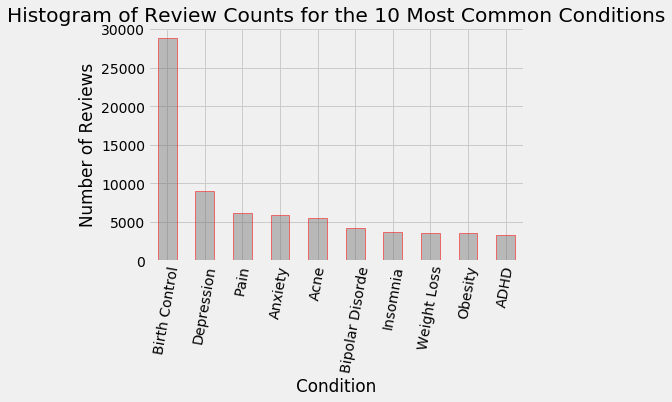

In [27]:
# 10 most common conditions
conditions = df.condition.value_counts().sort_values(ascending=False)
conditions[:10]
conditions[:10].plot(kind='bar', color=tuple(.4 for i in range(4)), edgecolor='red')
plt.title('Histogram of Review Counts for the 10 Most Common Conditions')
plt.xlabel('Condition')
plt.xticks(rotation=80)
plt.ylabel('Number of Reviews');